c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\joshu\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


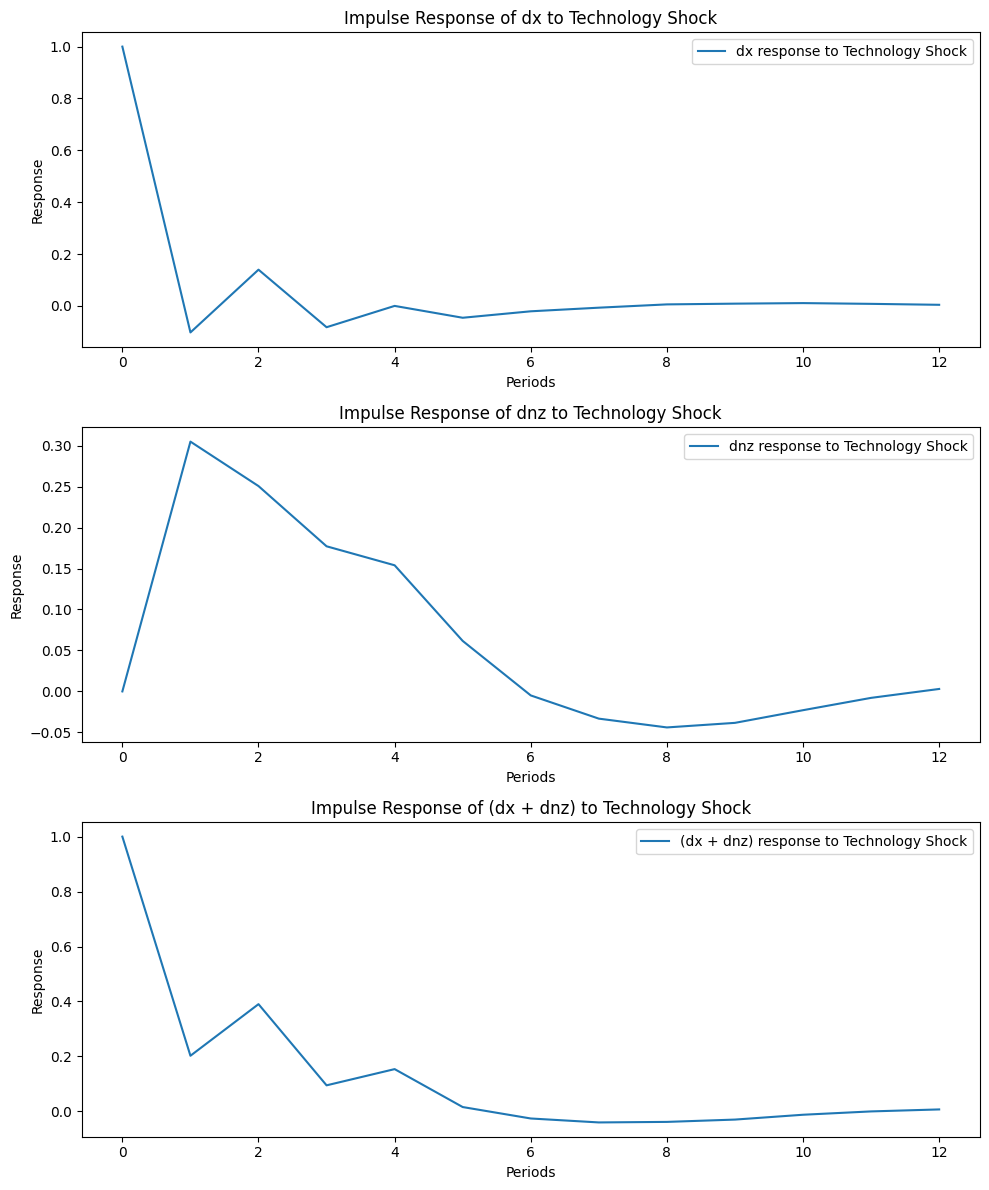

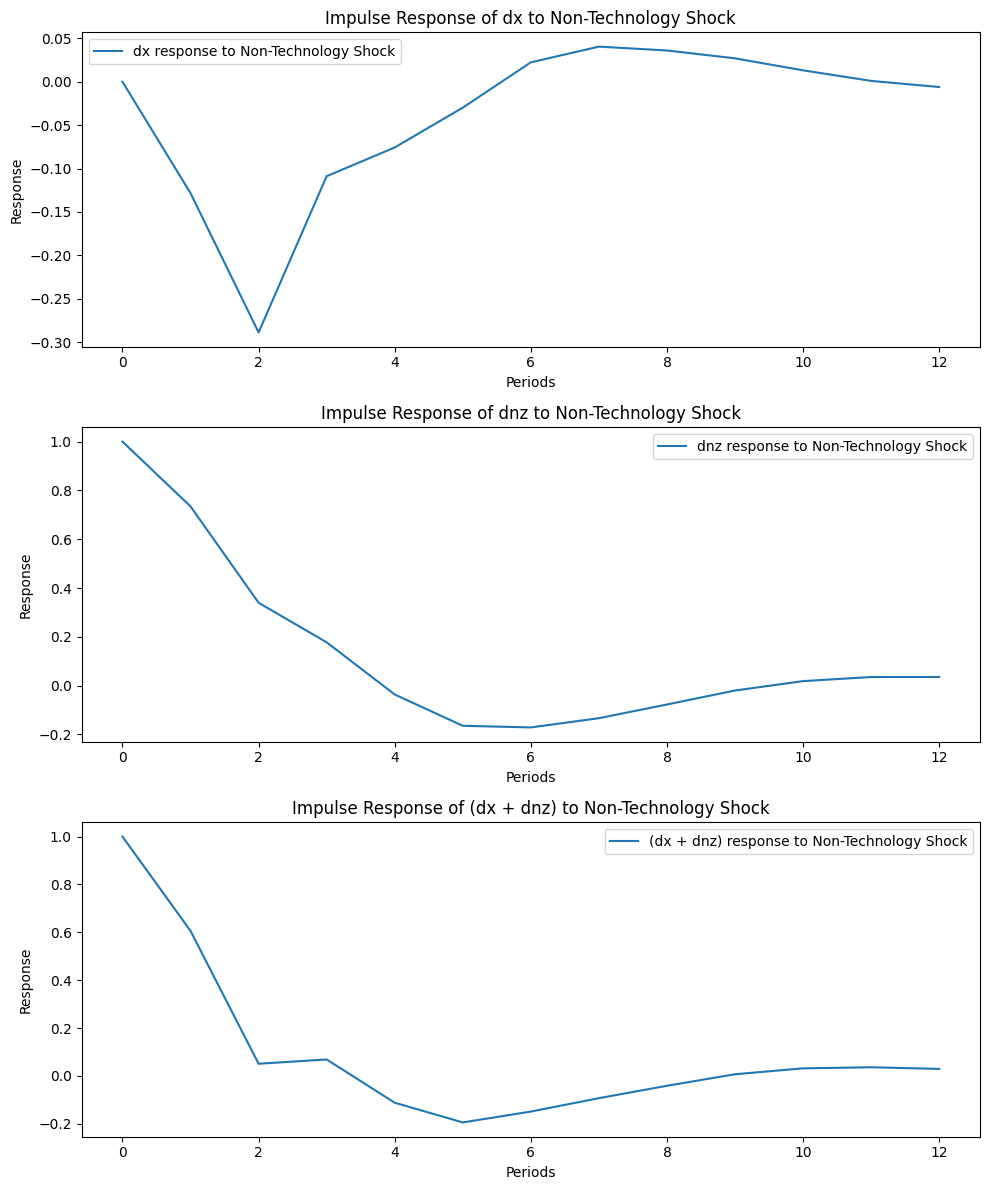

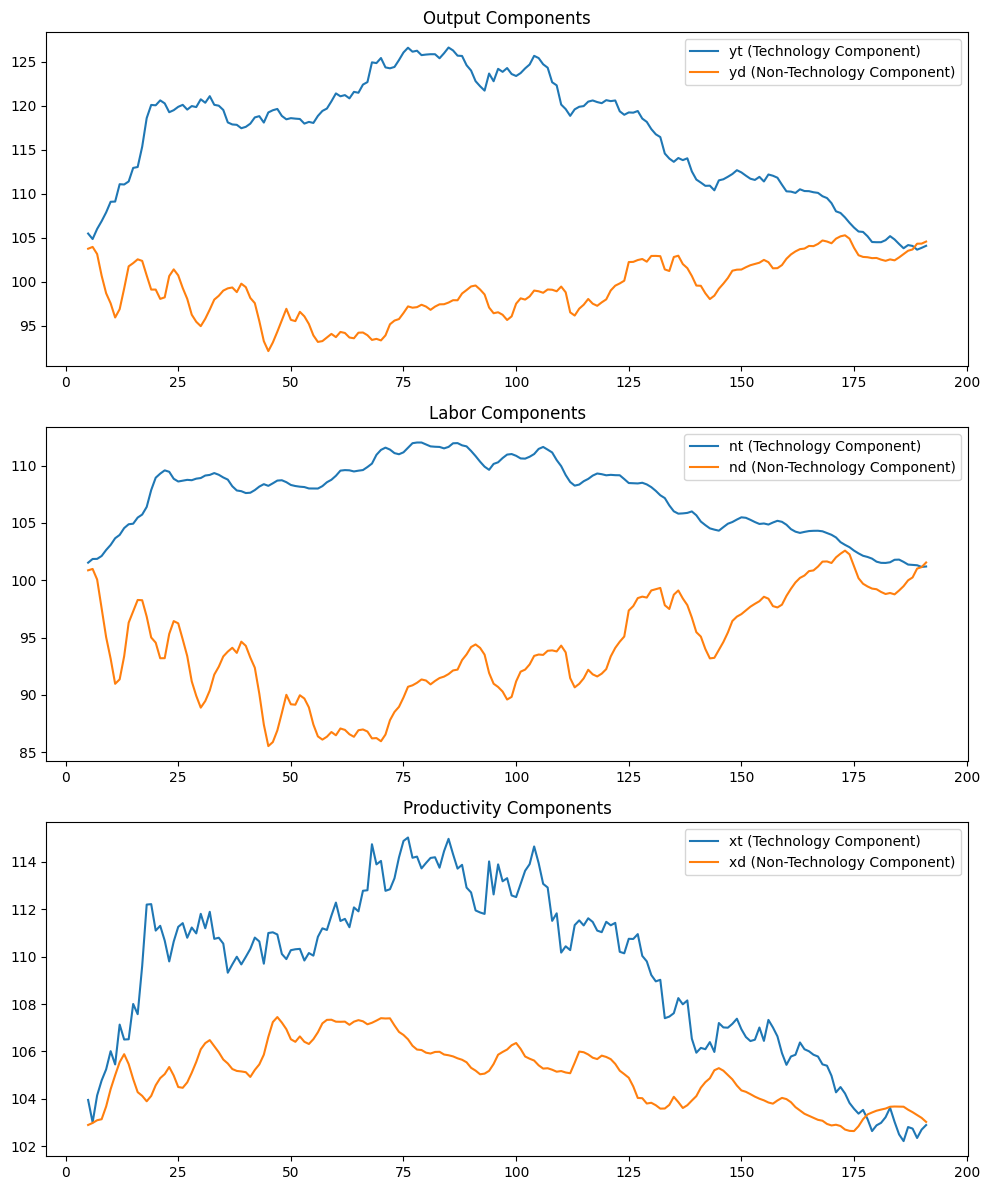

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm

# Step 1: Load the data
# Assuming the Excel file is named 'data.xlsx' and has columns 'Date', 'GDPQ', 'LHEM', 'LPMHU'
data = pd.read_excel('DATA.xlsx')


# Set parameters
country = 'US'
nchoice = 2  # 1 for employment ('LHEM'), 2 for hours ('LPMHU')
nint = 1     # 1 if 'n' is I(1), 0 if 'n' is I(0)
difn = 'yes' # 'yes' to compute correlations based on employment growth
LAGS = 4     # Number of lags in VAR
NSTEP = 100  # Number of steps for impulse responses
NDRAWS = 500 # Number of Monte Carlo simulations
NSE = 2      # Number of standard errors for confidence bands
IRH = 13     # Horizon for impulse response plots

# Step 2: Define variables based on nchoice
if nchoice == 1:
    nx = data['LHEM']
    labor = 'employment'
elif nchoice == 2:
    nx = data['LPMHU']
    labor = 'hours'

# Step 3: Compute variables
yx = data['GDPQ']
xx = yx / nx

# Create index numbers starting at 100
y = 100 + 100 * np.log(yx / yx.iloc[0])
n = 100 + 100 * np.log(nx / nx.iloc[0])
x = 100 + 100 * np.log(xx / xx.iloc[0])

# Compute first differences
dy = y.diff()
dn = n.diff()
dx = x.diff()

# Compute second differences
d2y = dy.diff()
d2n = dn.diff()
d2x = dx.diff()

# HP-filter the series
cycle_y, trend_y = hpfilter(y, lamb=1600)
yhp = cycle_y
cycle_n, trend_n = hpfilter(n, lamb=1600)
nhp = cycle_n
cycle_x, trend_x = hpfilter(x, lamb=1600)
xhp = cycle_x

# Step 4: Transform 'n' based on nint and difn
if nint == 0:
    # Detrend 'n' by regressing on a constant and trend
    trend = np.arange(len(n))
    n_df = pd.DataFrame({'n': n.values, 'trend': trend})
    n_df = n_df.dropna()
    n_coeffs = np.polyfit(n_df['trend'], n_df['n'], 1)
    n_trend = np.polyval(n_coeffs, trend)
    n_res = n - n_trend
    dnz = n_res
    trans = 'detrended'
else:
    dnz = dn
    trans = 'first differences'

if nint == 0 and difn == 'no':
    dn = n_res

# Step 5: Unconditional Cross Correlograms
# Compute cross-correlations between dy, dx, dn
# Here, we use the numpy.correlate function for cross-correlation

def cross_correlation(series1, series2, max_lag):
    correlations = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(series1[-lag:], series2[:lag])[0,1]
        elif lag > 0:
            corr = np.corrcoef(series1[:-lag], series2[lag:])[0,1]
        else:
            corr = np.corrcoef(series1, series2)[0,1]
        correlations.append(corr)
    return correlations

nstep = 20  # Number of steps for cross-correlograms
cdydx = cross_correlation(dy.dropna(), dx.dropna(), nstep)
cdydn = cross_correlation(dy.dropna(), dn.dropna(), nstep)
cdxdn = cross_correlation(dx.dropna(), dn.dropna(), nstep)

cyxhp = cross_correlation(yhp.dropna(), xhp.dropna(), nstep)
cynhp = cross_correlation(yhp.dropna(), nhp.dropna(), nstep)
cxnhp = cross_correlation(xhp.dropna(), nhp.dropna(), nstep)

# Step 6: Reduced-Form VAR
# Prepare data for VAR
var_data = pd.DataFrame({'dx': dx, 'dnz': dnz}).dropna()

# Estimate the VAR model
model = VAR(var_data)
results = model.fit(LAGS)

# Get residuals and covariance matrix
residuals = results.resid
sigmat = np.cov(residuals.T)

# Step 7: Structural VAR Identification
# Identify the SVAR using long-run restrictions
# The restriction is that only technology shocks have a permanent effect on 'dx'
# This is implemented by setting the long-run impact matrix A as:
# A = [[a11, 0],
#      [a21, a22]]

from statsmodels.tsa.vector_ar.irf import IRAnalysis

# Prepare the long-run restriction matrix
A_longrun = np.array([['E', 0],
                      ['E', 'E']])

# Estimate the SVAR model with long-run restrictions
svar_model = SVAR(var_data, svar_type='A', A=A_longrun)
svar_results = svar_model.fit(maxlags = LAGS)

# Step 8: Impulse Responses
# Compute impulse responses up to NSTEP periods
irf = svar_results.irf(NSTEP)
irfs = irf.irfs  # Shape: (NSTEP+1, nvars, nvars)

# Extract the impulse responses
c11 = irfs[:, 0, 0]  # Response of 'dx' to technology shock
c12 = irfs[:, 0, 1]  # Response of 'dx' to non-technology shock
c21 = irfs[:, 1, 0]  # Response of 'dnz' to technology shock
c22 = irfs[:, 1, 1]  # Response of 'dnz' to non-technology shock

# Adjust 'c21' and 'c22' if 'nint' == 0 and 'difn' == 'yes'
if nint == 0 and difn == 'yes':
    c21_adjusted = np.concatenate(([c21[0]], np.diff(c21)))
    c22_adjusted = np.concatenate(([c22[0]], np.diff(c22)))
    c21 = c21_adjusted
    c22 = c22_adjusted

# Compute cumulative impulse responses
c11s = np.cumsum(c11)
c12s = np.cumsum(c12)
c21s = np.cumsum(c21)
c22s = np.cumsum(c22)

# Step 9: Historical Decomposition
# Compute the structural shocks
eps = svar_results.resid  # Structural shocks: [eps1, eps2]

# Initialize arrays to store historical decompositions
hd11 = []
hd12 = []
hd21 = []
hd22 = []

# Number of observations
n_obs = len(eps)

# Compute the contributions of each shock to 'dx' and 'dnz'
for t in range(n_obs):
    hd11_t = 0
    hd12_t = 0
    hd21_t = 0
    hd22_t = 0
    for i in range(min(t + 1, NSTEP + 1)):
        hd11_t += c11[i] * eps[t - i, 0]
        hd12_t += c12[i] * eps[t - i, 1]
        hd21_t += c21[i] * eps[t - i, 0]
        hd22_t += c22[i] * eps[t - i, 1]
    hd11.append(hd11_t)
    hd12.append(hd12_t)
    hd21.append(hd21_t)
    hd22.append(hd22_t)

# Convert lists to arrays
hd11 = np.array(hd11)
hd12 = np.array(hd12)
hd21 = np.array(hd21)
hd22 = np.array(hd22)

# Compute 'dx', 'dnz', 'dxt', 'dnt', 'dxd', 'dnd'
dxt = hd11
dnt = hd21
dxd = hd12
dnd = hd22

# Compute 'dyt' and 'dyd'
dyt = dxt + dnt
dyd = dxd + dnd

# Accumulate to get levels 'yt', 'nt', 'xt', 'yd', 'nd', 'xd'
yt = np.cumsum(dyt) + y.iloc[LAGS + 1]
nt = np.cumsum(dnt) + n.iloc[LAGS + 1]
xt = np.cumsum(dxt) + x.iloc[LAGS + 1]
yd = np.cumsum(dyd) + y.iloc[LAGS + 1]
nd = np.cumsum(dnd) + n.iloc[LAGS + 1]
xd = np.cumsum(dxd) + x.iloc[LAGS + 1]

# Convert to pandas Series with appropriate dates
dates = var_data.index[LAGS:]
yt = pd.Series(yt, index=dates)
nt = pd.Series(nt, index=dates)
xt = pd.Series(xt, index=dates)
yd = pd.Series(yd, index=dates)
nd = pd.Series(nd, index=dates)
xd = pd.Series(xd, index=dates)

# Step 10: HP-filter the historical components
cycle_yt, trend_yt = hpfilter(yt, lamb=1600)
ythp = cycle_yt
cycle_nt, trend_nt = hpfilter(nt, lamb=1600)
nthp = cycle_nt
cycle_xt, trend_xt = hpfilter(xt, lamb=1600)
xthp = cycle_xt

cycle_yd, trend_yd = hpfilter(yd, lamb=1600)
ydhp = cycle_yd
cycle_nd, trend_nd = hpfilter(nd, lamb=1600)
ndhp = cycle_nd
cycle_xd, trend_xd = hpfilter(xd, lamb=1600)
xdhp = cycle_xd

# Step 11: Conditional Statistics
# Compute variances and correlations
# Technology component
dyt_var = np.var(dyt)
dnt_var = np.var(dnt)
dxt_var = np.var(dxt)
cor_dyt_dxt = np.corrcoef(dyt, dxt)[0, 1]
cor_dyt_dnt = np.corrcoef(dyt, dnt)[0, 1]
cor_dxt_dnt = np.corrcoef(dxt, dnt)[0, 1]

# Non-technology component
dyd_var = np.var(dyd)
dnd_var = np.var(dnd)
dxd_var = np.var(dxd)
cor_dyd_dxd = np.corrcoef(dyd, dxd)[0, 1]
cor_dyd_dnd = np.corrcoef(dyd, dnd)[0, 1]
cor_dxd_dnd = np.corrcoef(dxd, dnd)[0, 1]

# Step 12: Generate Figure 2 - Impulse Response Functions
# Plot impulse responses with confidence intervals

# Since 'statsmodels' does not provide standard errors for SVAR impulse responses,
# we can use bootstrap methods to estimate them
# For simplicity, we'll plot the impulse responses without confidence intervals

# Plot impulse responses to technology shock
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
axes[0].plot(c11[:IRH], label='dx response to Technology Shock')
axes[0].set_title('Impulse Response of dx to Technology Shock')
axes[0].set_xlabel('Periods')
axes[0].set_ylabel('Response')
axes[0].legend()

axes[1].plot(c21[:IRH], label='dnz response to Technology Shock')
axes[1].set_title('Impulse Response of dnz to Technology Shock')
axes[1].set_xlabel('Periods')
axes[1].set_ylabel('Response')
axes[1].legend()

axes[2].plot((c11 + c21)[:IRH], label='(dx + dnz) response to Technology Shock')
axes[2].set_title('Impulse Response of (dx + dnz) to Technology Shock')
axes[2].set_xlabel('Periods')
axes[2].set_ylabel('Response')
axes[2].legend()

plt.tight_layout()
plt.show()

# Plot impulse responses to non-technology shock
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
axes[0].plot(c12[:IRH], label='dx response to Non-Technology Shock')
axes[0].set_title('Impulse Response of dx to Non-Technology Shock')
axes[0].set_xlabel('Periods')
axes[0].set_ylabel('Response')
axes[0].legend()

axes[1].plot(c22[:IRH], label='dnz response to Non-Technology Shock')
axes[1].set_title('Impulse Response of dnz to Non-Technology Shock')
axes[1].set_xlabel('Periods')
axes[1].set_ylabel('Response')
axes[1].legend()

axes[2].plot((c12 + c22)[:IRH], label='(dx + dnz) response to Non-Technology Shock')
axes[2].set_title('Impulse Response of (dx + dnz) to Non-Technology Shock')
axes[2].set_xlabel('Periods')
axes[2].set_ylabel('Response')
axes[2].legend()

plt.tight_layout()
plt.show()

# Step 13: Additional Figures and Statistics
# You can generate additional plots and compute more statistics as needed

# For example, plot the historical components
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))
axes[0].plot(yt, label='yt (Technology Component)')
axes[0].plot(yd, label='yd (Non-Technology Component)')
axes[0].set_title('Output Components')
axes[0].legend()

axes[1].plot(nt, label='nt (Technology Component)')
axes[1].plot(nd, label='nd (Non-Technology Component)')
axes[1].set_title('Labor Components')
axes[1].legend()

axes[2].plot(xt, label='xt (Technology Component)')
axes[2].plot(xd, label='xd (Non-Technology Component)')
axes[2].set_title('Productivity Components')
axes[2].legend()

plt.tight_layout()
plt.show()


In [6]:
xd

5      102.897695
6      102.983343
7      103.097696
8      103.141022
9      103.680195
          ...    
187    103.543078
188    103.437659
189    103.319623
190    103.198012
191    103.028019
Length: 187, dtype: float64